<a href="https://colab.research.google.com/github/kozz84/particle_analysis/blob/main/Article_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import scipy
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns
import scipy.stats
from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb

Mounted at /content/drive


In [2]:
df = pd.read_csv("/content/drive/MyDrive/CIOP/images/df.csv")

In [3]:
df

,mean_intensity,area,extent,eccentricity,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,feret_diameter_max,...,convex_image,img,convex_perimeter,circularity,aspect_ratio,solidity,convexity,filename,area_fraction,label
0,44.255319,578.356287,0.380567,0.775433,892.145337,27.136435,40.826682,25.779193,125.667879,50.225669,...,[[False False True False False False False Fa...,"[array([[ 96, 97, 99, 95, 85, 93, 84, 8...",125.491598,0.678388,0.631430,0.648276,0.998597,210902_#1_50_10_1um_i004.tif,516.940327,0
1,13.791667,295.330870,0.500000,0.811877,393.774493,19.391414,28.140599,16.429302,84.262928,31.375727,...,[[False False False False False False False Fa...,"[array([[111, 113, 106, 111, 114, 105, 89, 10...",74.766633,0.722974,0.583829,0.750000,0.887302,210902_#1_50_10_1um_i004.tif,263.969529,0
2,16.066667,276.872691,0.441176,0.951442,430.690852,18.775656,40.863839,12.579055,83.059202,42.240865,...,[[False False False False True True True T...,"[array([[ 81, 83, 98, 93, 117, 114, 105, 9...",83.059202,0.710162,0.307829,0.642857,1.000000,210902_#1_50_10_1um_i004.tif,247.471433,0
3,34.584337,1021.352592,0.399038,0.834056,1839.665212,36.061427,63.447555,35.002771,232.166887,66.187168,...,[[False False False False False False False Fa...,"[array([[101, 109, 100, 95, 109, 116, 116, 11...",175.189118,0.487969,0.551680,0.555184,0.754583,210902_#1_50_10_1um_i004.tif,912.894621,0
4,15.392857,344.552682,0.388889,0.870760,584.509014,20.945121,36.982017,18.184369,107.526452,39.996361,...,[[False False False False False False True T...,"[array([[109, 109, 117, 110, 109, 98, 108, 11...",93.759223,0.611952,0.491708,0.589474,0.871964,210902_#1_50_10_1um_i004.tif,307.964450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12532,46.785714,430.690852,0.448718,0.900363,578.356287,23.417357,39.275320,17.090254,103.857380,37.862716,...,[[False False False False False False False Fa...,"[array([[ 85, 91, 103, 97, 84, 93, 95, 11...",90.853172,0.708354,0.435140,0.744681,0.874788,210902_#9_150_30_1um_i005,427.746204,1
12533,23.569620,486.065390,0.357466,0.901795,842.923525,24.877252,47.152383,20.377554,124.977876,46.603781,...,[[False False False False False False False Fa...,"[array([[121, 123, 115, 123, 129, 136, 122, 13...",112.751812,0.625344,0.432164,0.576642,0.902174,210902_#9_150_30_1um_i005,482.742144,1
12534,33.546392,596.814467,0.629870,0.624723,664.494458,27.566062,31.637453,24.703984,92.306198,35.079129,...,[[False False False False False False False T...,"[array([[ 93, 112, 105, 112, 115, 114, 114, 11...",92.306198,0.938196,0.780846,0.898148,1.000000,210902_#9_150_30_1um_i005,592.734025,1
12535,19.449438,547.592655,0.539394,0.832397,726.021722,26.404860,37.887667,20.996593,108.392737,38.507234,...,[[False False False False False False False Fa...,"[array([[ 98, 113, 108, 100, 113, 114, 96, 10...",100.173186,0.765303,0.554180,0.754237,0.924169,210902_#9_150_30_1um_i005,543.848745,1


In [4]:
skew = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
skew['skew'] = scipy.stats.skew(df.select_dtypes(np.number))
skew['skew_abs'] = skew['skew'].apply(abs)
skew['skewed'] = skew['skew_abs'].apply(lambda x: True if x>=0.5 else False)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocessing(df):
    temp = df[(df['equivalent_diameter']>0)].copy()
    temp = temp[temp['filename']!= '210902_#9_150_30_1um_i005']
    file_col = pd.DataFrame(columns=['filename'])
    file_col['filename'] = temp['filename'].copy()
    for column in skew.query('skewed == True')['Feature'].values:
        temp[column] = np.log1p(temp[column])
    y = temp['label']
    X = temp.drop(['filename','label','image','convex_image','img'],axis=1)
    check = X.copy()
    X_df = X.copy()
    scaler = StandardScaler()
    columns_names = X.columns
    X = scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True,random_state=222)
    return X,y,X_train,X_test,y_train,y_test, file_col,columns_names,X_df, check
X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df, check = preprocessing(df)

In [6]:
correlation = X_df.rename(columns={'mean_intensity': 'I', 
                        'area': 'A',
                        'extent': 'E$_X$', 
                        'eccentricity': 'E$_C$',
                        'convex_area': ' A$_C$',
                        'equivalent_diameter': 'd$_E$',
                        'major_axis_length': 'a', 
                        'minor_axis_length': 'b',
                        'perimeter': 'P',
                        'feret_diameter_max':'F$_{MAX}$',
                        'convex_perimeter':'P$_C$',
                        'circularity':'C',
                        'aspect_ratio': 'AR',
                        'solidity': 'S',
                        'convexity': 'C',
                        'area_fraction': 'A$_F$'
        })

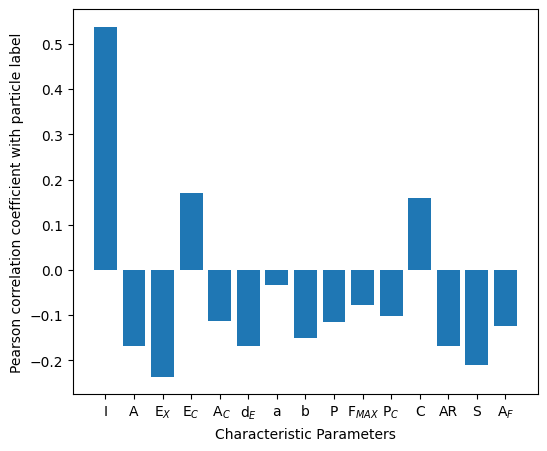

In [104]:
fig, ax = plt.subplots(figsize=(6,5))
ax.bar(correlation.columns, correlation.corrwith(y).values)

ax.set_ylabel('Pearson correlation coefficient with particle label')
ax.set_xlabel('Characteristic Parameters')
plt.show()
fig.savefig('fig_4.png', format='png',bbox_inches = "tight")
fig.savefig('fig_4.eps', format='eps',bbox_inches = "tight")

In [43]:
from sklearn.cluster import SpectralClustering, KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score

In [44]:
cluster_models = {
    'Spectral Clustering':SpectralClustering(n_clusters=2,
                            affinity='nearest_neighbors',
                            assign_labels='kmeans',
                            random_state=464
                            ),
    'Spectral Biclustering': KMeans(n_clusters=2),
    'AgglomerativeClustering':AgglomerativeClustering(),
    "DBSCAN":DBSCAN(eps=9.7, min_samples=2, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
}

cluster_score = []
cluster_results = pd.DataFrame()
cluster_results['true'] = y
for name,cluster_model in cluster_models.items():
    cluster_model.fit(X)
    print(confusion_matrix(y,cluster_model.labels_))
    cluster_score.append([name,accuracy_score(y,cluster_model.labels_)])
    cluster_results[name] = cluster_model.labels_
cluster_score = pd.DataFrame(cluster_score, columns=['model name', 'Accuracy'])
cluster_score.sort_values('Accuracy',ascending=False)

[[1488 4437]
 [1649 4024]]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[4078 1847]
 [3777 1896]]
[[2411 3514]
 [2240 3433]]
[[5925    0]
 [5673    0]]


,model name,Accuracy
1,Spectral Biclustering,0.515089
3,DBSCAN,0.510864
2,AgglomerativeClustering,0.503880
0,Spectral Clustering,0.475254


In [45]:
def NN_model():
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(4,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer = 'adam',
                loss='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', 
                            mode='min',
                            verbose=1,
                            patience=25)
    return model
y.value_counts()

0    5925
1    5673
Name: label, dtype: int64

In [46]:
X.shape

(11598, 16)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)

In [49]:
for i in range (10):
    X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df,check = preprocessing(df)
    NN_model()
    model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)
    y_pred = pd.DataFrame((model.predict(X) > 0.5).astype("int32"))
    print(i,accuracy_score(y,y_pred))
    print(confusion_matrix(y,y_pred))

Epoch 108: early stopping
363/363 [==============================] - 1s 1ms/step
0 0.9520607001207104
[[5605  320]
 [ 236 5437]]
Epoch 27: early stopping
363/363 [==============================] - 0s 1ms/step
1 0.9569753405759613
[[5584  341]
 [ 158 5515]]
Epoch 26: early stopping
363/363 [==============================] - 1s 3ms/step
2 0.9618037592688394
[[5716  209]
 [ 234 5439]]
Epoch 28: early stopping
363/363 [==============================] - 0s 1ms/step
3 0.9605104328332471
[[5786  139]
 [ 319 5354]]
Epoch 26: early stopping
363/363 [==============================] - 0s 1ms/step
4 0.960079324021383
[[5683  242]
 [ 221 5452]]
Epoch 26: early stopping
363/363 [==============================] - 1s 2ms/step
5 0.9605966545956199
[[5724  201]
 [ 256 5417]]
Epoch 33: early stopping
363/363 [==============================] - 0s 1ms/step
6 0.9599931022590101
[[5721  204]
 [ 260 5413]]
Epoch 37: early stopping
363/363 [==============================] - 1s 2ms/step
7 0.9624935333678221
[[5

In [95]:

def preprocessing(df):
    temp = df[(df['equivalent_diameter']>0)].copy()
    temp = temp[temp['filename']!= '210902_#9_150_30_1um_i005']
    file_col = pd.DataFrame(columns=['filename'])
    file_col['filename'] = temp['filename'].copy()
    for column in skew.query('skewed == True')['Feature'].values:
        temp[column] = np.log1p(temp[column])
    y = temp['label']
    X = temp.drop(['filename','label','image','convex_image','img'],axis=1)
    check = X.copy()
    X_df = X.copy()
    scaler = StandardScaler()
    columns_names = X.columns
    X = scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True,random_state=10871210)
    return X,y,X_train,X_test,y_train,y_test, file_col,columns_names,X_df, check
X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df, check = preprocessing(df)

In [96]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)
model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)

Epoch 95: early stopping


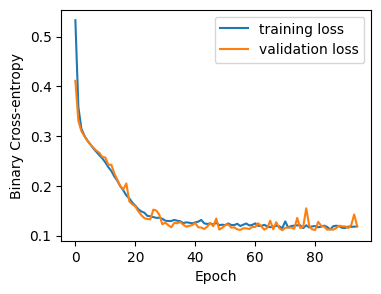

In [102]:
history = pd.DataFrame(model.history.history)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(history)
ax.set_ylabel('Binary Cross-entropy')
ax.set_xlabel('Epoch')
ax.legend(('training loss','validation loss'))
fig.savefig('fig_5.png',dpi=300,format='png',bbox_inches = "tight")
fig.savefig('fig_5.eps',dpi=300,format='eps',bbox_inches = "tight")

In [52]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame((model.predict(X_test) > 0.5).astype("int32"))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

109/109 [==============================] - 0s 1ms/step
0.9505747126436782
[[1723   49]
 [ 123 1585]]
F1 Score: 0.949
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1772
           1       0.97      0.93      0.95      1708

    accuracy                           0.95      3480
   macro avg       0.95      0.95      0.95      3480
weighted avg       0.95      0.95      0.95      3480



In [53]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
models = {
    'K-Neighbors Classifier':KNeighborsClassifier(),
          'Logistic Regression':LogisticRegression(max_iter=500),
          'SVC': SVC(),
         'Decision Tree Classifier':DecisionTreeClassifier(),
          'Random Forest Classifier':RandomForestClassifier(),
      #    'Ad aBoost Classifier':AdaBoostClassifier(),
        #  'Gaussian NB':GaussianNB()
         }
score = []
x=0
#results = pd.DataFrame(y_test)
for name,model in models.items():
    x+=1
    #model.fit(X,y)
   # y_pred = model.predict(X_test)
    cvs = cross_val_score(estimator= model,X=X,y=y,cv=10)
    acc = cvs.mean()
    std = cvs.std()
    #score.append([name,accuracy_score(y_test,y_pred)])
    print(x,'/',len(models),name,round(acc,3),round(std,3))
    #y_pred = cross_val_predict(model, X=X, y=y, cv=10)
    #print(confusion_matrix(y, y_pred)) 
    score.append([name,acc, std])

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(confusion_matrix(y_test, y_pred)) 
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    classification_report
    #results[name] = y_pred
score = pd.DataFrame(score, columns=['model name', 'Accuracy','std'])

1 / 5 K-Neighbors Classifier 0.875 0.015
K-Neighbors Classifier
[[1595  177]
 [ 277 1431]]
F1 Score: 0.863
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1772
           1       0.89      0.84      0.86      1708

    accuracy                           0.87      3480
   macro avg       0.87      0.87      0.87      3480
weighted avg       0.87      0.87      0.87      3480

2 / 5 Logistic Regression 0.924 0.053
Logistic Regression
[[1668  104]
 [ 164 1544]]
F1 Score: 0.920
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1772
           1       0.94      0.90      0.92      1708

    accuracy                           0.92      3480
   macro avg       0.92      0.92      0.92      3480
weighted avg       0.92      0.92      0.92      3480

3 / 5 SVC 0.909 0.019
SVC
[[1659  113]
 [ 237 1471]]
F1 Score: 0.894
              precision    recall  f1-score   support

           0  